# Annotations analysis

In this script, we:
- explore the annotations,
- explore the perception of bias.

To run this script, the following data files are needed (attached):
- labeled_dataset.xlsx
- annotations_final_notempty.xlsx
- results_bias.xlsx

In [19]:
# data
import pandas as pd
import numpy as np

# misc
import os
import re
import time
import ast
import copy

# statistics
import statistics
import statsmodels
from statsmodels.stats import inter_rater
import krippendorff

# visualizations
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import plotly.express as px
from matplotlib import colors

In [20]:

labeled_sentences = pd.read_excel('data/labeled_dataset.xlsx',engine='openpyxl')
labeled_sentences["biased_words"] = labeled_sentences.biased_words4.apply(lambda s: list(ast.literal_eval(s)))
labeled_sentences.head(2)

,Unnamed: 0,sentence,news_link,outlet,topic,type,group_id,num_sent,Label_bias,Label_opinion,article,biased_words4,biased_words
0,0,YouTube is making clear there will be no “birt...,https://eu.usatoday.com/story/tech/2020/02/03/...,usa-today,elections-2020,center,1,1,Biased,Somewhat factual but also opinionated,YouTube says no ‘deepfakes’ or ‘birther’ video...,"['belated', 'birtherism']","[belated, birtherism]"
1,1,The increasingly bitter dispute between Americ...,https://www.nbcnews.com/news/sports/women-s-te...,msnbc,sport,left,1,1,Non-biased,Entirely factual,"FRISCO, Texas — The increasingly bitter disput...",['bitter'],[bitter]


In [22]:

annotations = pd.read_excel('data/annotations_final_notempty.xlsx',engine='openpyxl')
annotations['political_ideology_lcr'] = annotations['political_ideology'].apply(lambda x: "left" if x < -3
                                                                                else ("right" if x > 3 else "center"))
annotations["followed_news_outlets"] = annotations.followed_news_outlets.apply(lambda s: list(ast.literal_eval(s)))

annotations.head(2)


,Unnamed: 0.1,Unnamed: 0,survey_record_id,sentence_id,group_id,created_at,label,words,factual,group_id.1,...,mturk_id,age,gender,education,native_english_speaker,political_ideology,followed_news_outlets,news_check_frequency,survey_completed,political_ideology_lcr
0,0,19227,73a9148bc907314e086de8debe345824,1942,67,NaN,Biased,"match-fixing,infamous,notorious",Entirely factual,67,...,73a9148bc907314e086de8debe345824,26.0,prefer not to say,graduate work,near native,18,"[Reuters, BuzzFeed]",several times per month,True,right
1,1,19228,73a9148bc907314e086de8debe345824,1620,67,NaN,Biased,high,Expresses writer’s opinion,67,...,73a9148bc907314e086de8debe345824,26.0,prefer not to say,graduate work,near native,18,"[Reuters, BuzzFeed]",several times per month,True,right


In [23]:
results_bias = pd.read_excel('data/results_bias.xlsx',engine='openpyxl')
results_bias.head(2)

,sentence,Biased,Non-biased,Label_bias,Total_annotations
0,"Orange Is the New Black"" star Yael Stone is re...",0,1,Non-biased,1
1,A 10-hour hearing broadcast on the courtâ€™s w...,0,1,Non-biased,1


## 1 Annotations exploration

In [24]:
labeled_sentences['num_biased_words'] = labeled_sentences.biased_words.apply(lambda row: len(row))
sent_with_biased_words = labeled_sentences[labeled_sentences['num_biased_words']>0]
print('Average number of biased words in the senetcne:', int(sent_with_biased_words.num_biased_words.mean()))

Average number of biased words in the senetcne: 2


In [25]:
# bias vs non-bias
bias_obs = labeled_sentences.groupby(['Label_bias'])[['sentence']].count()
bias_obs = bias_obs.reset_index()
bias_obs = bias_obs.rename(columns={"sentence": "num_sentences"})
bias_obs['sorting'] = [1, 3, 2]
bias_obs = bias_obs.sort_values(by=['sorting']).reset_index()
bias_obs = bias_obs[['Label_bias','num_sentences']]

bias_obs

,Label_bias,num_sentences
0,Biased,1018
1,Non-biased,533
2,No agreement,149


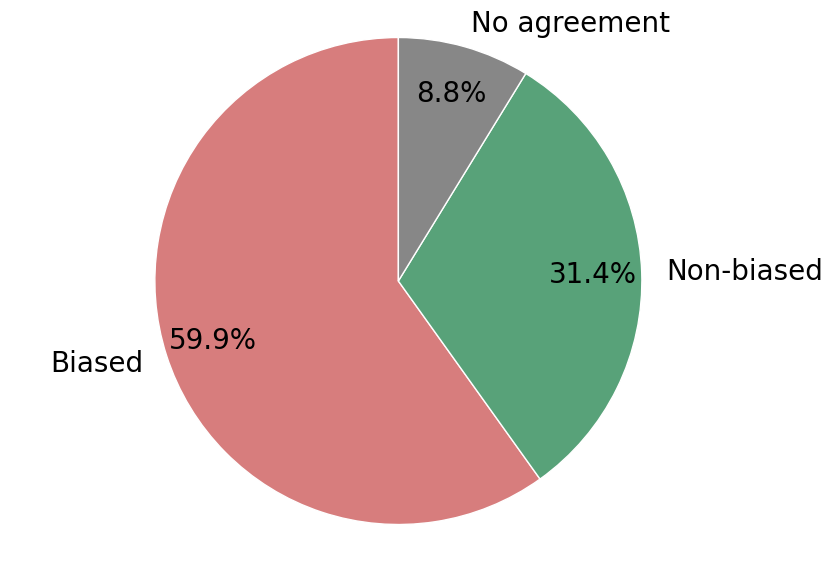

In [26]:
cols = np.array([
    np.array(colors.to_rgba('indianred', alpha=0.8)),
    np.array(colors.to_rgba('seagreen', alpha=0.8)),
    np.array(colors.to_rgba('dimgray', alpha=0.8))])

def my_autopct(pct):
    return ('%.1f%%' % pct) if pct > 2 else ''

fig1, ax1 = plt.subplots(figsize=(10,7))
my_pie = ax1.pie(bias_obs.num_sentences, labels=bias_obs.Label_bias,
        startangle=90, textprops={'fontsize': 20}, #labeldistance=None,
        autopct=my_autopct, pctdistance=0.8,
       colors=cols)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#ax1.legend(loc='upper right', bbox_to_anchor=(1.15, 0.95))

for pie_wedge in my_pie[0]:
    pie_wedge.set_edgecolor('white')

plt.show()

In [27]:
# opinionated vs factual
opin_obs = labeled_sentences.groupby(['Label_opinion'])[['sentence']].count()
opin_obs = opin_obs.reset_index()
opin_obs = opin_obs.rename(columns={"sentence": "num_sentences"})
opin_obs['sorting'] = [1, 3, 4, 2]
opin_obs = opin_obs.sort_values(by=['sorting']).reset_index()
opin_obs = opin_obs[['Label_opinion','num_sentences']]
opin_obs = opin_obs.replace('Entirely factual', 'Factual')
opin_obs = opin_obs.replace('Expresses writer’s opinion', 'Opinionated')
opin_obs = opin_obs.replace('Somewhat factual but also opinionated', 'Both')

opin_obs

,Label_opinion,num_sentences
0,Factual,572
1,Both,433
2,Opinionated,521
3,No agreement,174


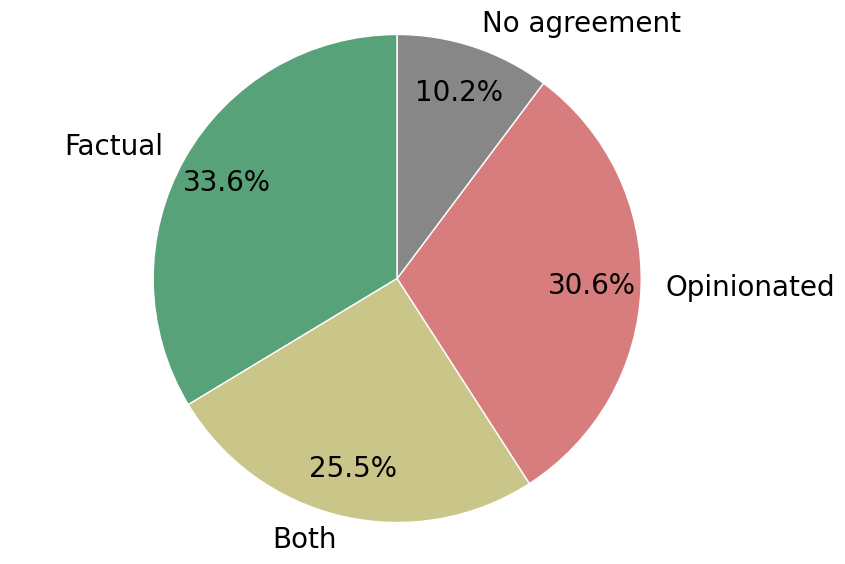

In [28]:
cols = np.array([
    np.array(colors.to_rgba('seagreen', alpha=0.8)),
    np.array(colors.to_rgba('darkkhaki', alpha=0.8)),
    np.array(colors.to_rgba('indianred', alpha=0.8)),
    np.array(colors.to_rgba('dimgray', alpha=0.8))])

def my_autopct(pct):
    return ('%.1f%%' % pct) if pct > 2 else ''

fig1, ax1 = plt.subplots(figsize=(10,7))
my_pie = ax1.pie(opin_obs.num_sentences, labels=opin_obs.Label_opinion,
        startangle=90, textprops={'fontsize': 20}, #labeldistance=None,
        autopct=my_autopct, pctdistance=0.8,
       colors=cols)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#ax1.legend(loc='upper right', bbox_to_anchor=(1.15, 0.95))

for pie_wedge in my_pie[0]:
    pie_wedge.set_edgecolor('white')

plt.show()

In [29]:
type_bias = labeled_sentences.groupby(['type','Label_bias'])[['sentence']].count()
type_bias = type_bias.reset_index()
type_bias = type_bias.rename(columns={"sentence": "num_sentences"})
type_bias = type_bias.replace('No agreement', 'No agr.')
type_bias

,type,Label_bias,num_sentences
0,center,Biased,88
1,center,No agr.,27
2,center,Non-biased,200
3,left,Biased,477
4,left,No agr.,57
5,left,Non-biased,160
6,right,Biased,453
7,right,No agr.,65
8,right,Non-biased,173


In [30]:
fig = px.sunburst(data_frame = type_bias,
                  path = ['type', 'Label_bias'],
                  values = 'num_sentences',
                  color='type',
                  color_discrete_map={'center':'thistle', 'left':'steelblue','right':'indianred'})
fig.update_traces(textfont_size=20)
fig.show()

In [31]:
type_opin = labeled_sentences.groupby(['type','Label_opinion'])[['sentence']].count()
type_opin = type_opin.reset_index()
type_opin = type_opin.rename(columns={"sentence": "num_sentences"})
type_opin = type_opin.replace('Entirely factual', 'Factual')
type_opin = type_opin.replace('Expresses writer’s opinion', 'Opinionated')
type_opin = type_opin.replace('Somewhat factual but also opinionated', 'Both')
type_opin = type_opin.replace('No agreement', 'No agr.')
type_opin

,type,Label_opinion,num_sentences
0,center,Factual,210
1,center,Opinionated,22
2,center,No agr.,31
3,center,Both,52
4,left,Factual,177
5,left,Opinionated,250
6,left,No agr.,58
7,left,Both,209
8,right,Factual,185
9,right,Opinionated,249


In [32]:
fig = px.sunburst(data_frame = type_opin,
                  path = ['type', 'Label_opinion'],
                  values = 'num_sentences',
                  color='type',
                  color_discrete_map={'center':'thistle', 'left':'steelblue','right':'indianred'})
fig.update_traces(textfont_size=20)
fig.show()

## 2 Bias perception

### 2.1 Bias perception across the topics

In [33]:
des_st_topics = pd.merge(labeled_sentences, results_bias[['sentence', 'Biased', 'Non-biased', 'Total_annotations']],
                           left_on = 'sentence', right_on = 'sentence',
                           how='left')
des_st_topics.head(3)

,Unnamed: 0,sentence,news_link,outlet,topic,type,group_id,num_sent,Label_bias,Label_opinion,article,biased_words4,biased_words,num_biased_words,Biased,Non-biased,Total_annotations
0,0,YouTube is making clear there will be no “birt...,https://eu.usatoday.com/story/tech/2020/02/03/...,usa-today,elections-2020,center,1,1,Biased,Somewhat factual but also opinionated,YouTube says no ‘deepfakes’ or ‘birther’ video...,"['belated', 'birtherism']","[belated, birtherism]",2,NaN,NaN,NaN
1,1,The increasingly bitter dispute between Americ...,https://www.nbcnews.com/news/sports/women-s-te...,msnbc,sport,left,1,1,Non-biased,Entirely factual,"FRISCO, Texas — The increasingly bitter disput...",['bitter'],[bitter],1,NaN,NaN,NaN
2,2,So while there may be a humanitarian crisis dr...,https://www.alternet.org/2019/01/here-are-5-of...,alternet,immigration,left,1,1,Biased,Expresses writer’s opinion,Speaking to the country for the first time fro...,['crisis'],[crisis],1,NaN,NaN,NaN


In [34]:
print('Is there missing values?', des_st_topics.isnull().values.any())
print('Number of missing values:\n', des_st_topics.isnull().sum())
des_st_topics = des_st_topics.fillna(0)

Is there missing values? True
Number of missing values:
 Unnamed: 0              0
sentence                0
news_link              19
outlet                  0
topic                   0
type                    0
group_id                0
num_sent                0
Label_bias              0
Label_opinion           0
article               100
biased_words4           0
biased_words            0
num_biased_words        0
Biased               1591
Non-biased           1591
Total_annotations    1591
dtype: int64


In [36]:
# group by topic and summarize the number of bias and non bias labels
a = des_st_topics.groupby(['topic'])[['Biased', 'Non-biased', 'Total_annotations']].sum()
b = pd.DataFrame(labeled_sentences.groupby(['topic'])['sentence'].count())

# divide these numbers by the number of sentences in each topic multiplied by 10
des_st_topics_grouped = pd.merge(a, b,
                           left_index = True, right_index = True,
                           how='left')
#des_st_topics_grouped["sen_annotations"] = des_st_topics_grouped.sentence * 10
des_st_topics_grouped["bias_perc"] = round(des_st_topics_grouped.Biased / des_st_topics_grouped.Total_annotations * 100, 1)
des_st_topics_grouped["nonbias_perc"] = round(des_st_topics_grouped["Non-biased"] / des_st_topics_grouped.Total_annotations * 100, 1)
des_st_topics_grouped = des_st_topics_grouped.reset_index()

des_st_topics_grouped["controversial"] = ["yes","yes","yes","yes","yes","yes","yes",
                                          "less","less","less","less","yes","yes","yes"]
des_st_topics_grouped = des_st_topics_grouped.sort_values(by=['controversial'], ascending=False)
des_st_topics_grouped = des_st_topics_grouped.replace('international-politics-and-world-news', 'int.-politics-&-world-news')

des_st_topics_grouped

,topic,Biased,Non-biased,Total_annotations,sentence,bias_perc,nonbias_perc,controversial
0,abortion,10.0,6.0,16.0,126,62.5,37.5,yes
1,coronavirus,13.0,2.0,15.0,122,86.7,13.3,yes
2,elections-2020,1.0,2.0,3.0,111,33.3,66.7,yes
3,environment,8.0,3.0,11.0,135,72.7,27.3,yes
4,gender,2.0,1.0,3.0,128,66.7,33.3,yes
5,gun-control,4.0,2.0,6.0,124,66.7,33.3,yes
6,immigration,14.0,3.0,17.0,122,82.4,17.6,yes
11,trump-presidency,3.0,4.0,7.0,120,42.9,57.1,yes
12,vaccines,1.0,1.0,2.0,122,50.0,50.0,yes
13,white-nationalism,2.0,2.0,4.0,131,50.0,50.0,yes


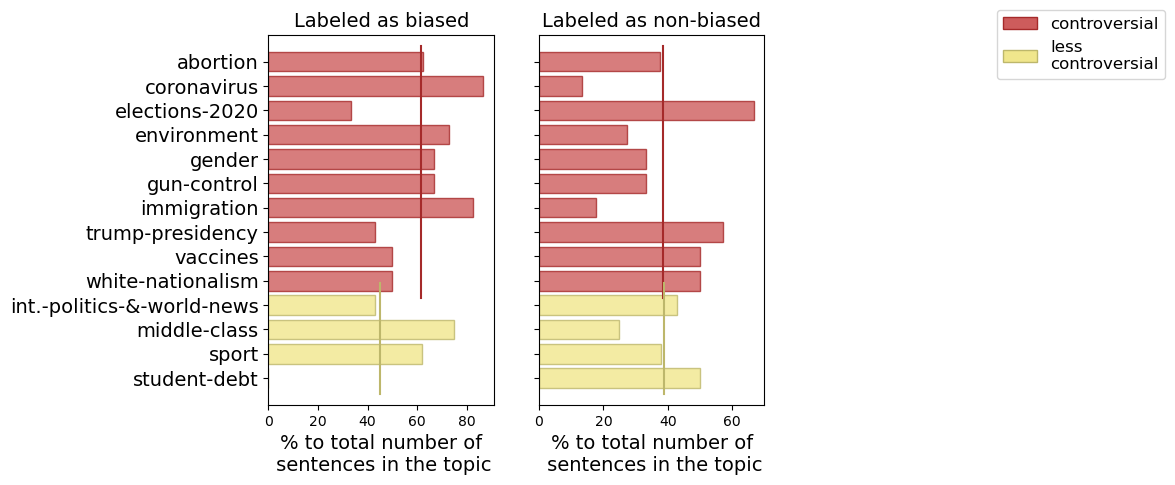

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2)
#fig.suptitle('Bias perception differences across the topics')
colors = ['indianred', 'indianred', 'indianred', 'indianred', 'indianred', 'indianred', 'indianred', 
          'indianred', 'indianred', 'indianred', 'khaki', 'khaki', 'khaki', 'khaki']
edgecolors = ['brown', 'brown', 'brown', 'brown', 'brown', 'brown', 'brown', 
          'brown', 'brown', 'brown', 'darkkhaki', 'darkkhaki', 'darkkhaki', 'darkkhaki']
legend_elements = [Patch(facecolor='indianred', edgecolor='brown', label='controversial'),
                   Patch(facecolor='khaki', edgecolor='darkkhaki', label='less\ncontroversial')]

# means
des_st_topics_grouped_contr = des_st_topics_grouped[des_st_topics_grouped['controversial']=="yes"]
des_st_topics_grouped_noncontr = des_st_topics_grouped[des_st_topics_grouped['controversial']=="less"]
contr_bias_mean = des_st_topics_grouped_contr['bias_perc'].mean()
contr_nonbias_mean = des_st_topics_grouped_contr['nonbias_perc'].mean()
noncontr_bias_mean = des_st_topics_grouped_noncontr['bias_perc'].mean()
noncontr_nonbias_mean = des_st_topics_grouped_noncontr['nonbias_perc'].mean()

# plots
   # biased
y_pos1 = np.arange(len(des_st_topics_grouped["topic"]))
ax1.barh(y_pos1, des_st_topics_grouped["bias_perc"], align='center', color=colors, alpha=0.8, edgecolor=edgecolors)
ax1.set_yticks(y_pos1)
ax1.set_yticklabels(des_st_topics_grouped["topic"], fontsize=14)
ax1.invert_yaxis() # labels read top-to-bottom
ax1.axvline(x = contr_bias_mean, ymin=0.29, ymax=0.97, linewidth=1.5, color='brown')
ax1.axvline(x = noncontr_bias_mean, ymin=0.03, ymax=0.33, linewidth=1.5, color='darkkhaki')
ax1.set_xlabel('% to total number of\n sentences in the topic', fontsize=14)
ax1.set_title('Labeled as biased', fontsize=14)

   # non-biased
y_pos2 = np.arange(len(des_st_topics_grouped["topic"]))
ax2.barh(y_pos2, des_st_topics_grouped["nonbias_perc"], align='center', color=colors, alpha=0.8, edgecolor=edgecolors) #
ax2.set_yticks(y_pos2)
ax2.set_yticklabels(des_st_topics_grouped["topic"])
ax2.invert_yaxis() # labels read top-to-bottom
ax2.axvline(x = contr_nonbias_mean, ymin=0.29, ymax=0.97, linewidth=1.5, color='brown')
ax2.axvline(x = noncontr_nonbias_mean, ymin=0.03, ymax=0.33, linewidth=1.5, color='darkkhaki')
ax2.set_xlabel('% to total number of\n sentences in the topic', fontsize=14)
ax2.set_title('Labeled as non-biased', fontsize=14)

ax2.label_outer()
fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.25, 0.95), fontsize=12)

plt.show()

### 2.2 Bias perception across the political ideologies

In [160]:
# group by sentence type, label and political ideology of an annotator
des_st_polit = annotations.groupby(['type','label','political_ideology_lcr'])[['sentence_id']].count()
des_st_polit = des_st_polit.reset_index()
des_st_polit = des_st_polit.rename(columns={"sentence_id": "num_participants"})

# add total number of participants to calculate ratio
participants_ideologies = annotations.groupby(['political_ideology_lcr'])[['sentence_id']].count()
participants_ideologies = participants_ideologies.rename(columns={"sentence_id": "total_participants"})
des_st_polit = pd.merge(des_st_polit, participants_ideologies,
                        left_on = 'political_ideology_lcr', right_index = True,
                        how = 'left')

# calculate ratio
des_st_polit["participants_ratio"] = round(des_st_polit["num_participants"]/des_st_polit["total_participants"]*100, 2)
des_st_polit

,type,label,political_ideology_lcr,num_participants,total_participants,participants_ratio


In [161]:
# separate data to biased and non-biased
des_st_polit_biased = des_st_polit[des_st_polit["label"]=="Biased"]
des_st_polit_nonbiased = des_st_polit[des_st_polit["label"]=="Non-biased"]

# percentage of annotations as biased and as non-biased
as_biased = round(sum(des_st_polit_biased.num_participants)/
                  (sum(des_st_polit_biased.num_participants)+sum(des_st_polit_nonbiased.num_participants))*100,2)

as_nonbiased = round(sum(des_st_polit_nonbiased.num_participants)/
                     (sum(des_st_polit_biased.num_participants)+sum(des_st_polit_nonbiased.num_participants))*100,2)

# data for both plots
sentences_types = ['center', 'left', 'right']
x = np.arange(len(sentences_types))
width = 0.2

     # data for plot (perceived as biased)
b_left_annotators = list(des_st_polit_biased[des_st_polit_biased["political_ideology_lcr"]=="left"].participants_ratio)
b_right_annotators = list(des_st_polit_biased[des_st_polit_biased["political_ideology_lcr"]=="right"].participants_ratio)
b_center_annotators = list(des_st_polit_biased[des_st_polit_biased["political_ideology_lcr"]=="center"].participants_ratio)

     # data for plot (perceived as non-biased)
nb_left_annotators = list(des_st_polit_nonbiased[des_st_polit_nonbiased["political_ideology_lcr"]=="left"].participants_ratio)
nb_right_annotators = list(des_st_polit_nonbiased[des_st_polit_nonbiased["political_ideology_lcr"]=="right"].participants_ratio)
nb_center_annotators = list(des_st_polit_nonbiased[des_st_polit_nonbiased["political_ideology_lcr"]=="center"].participants_ratio)



# plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

      # perceived as biased
b_rects_l = ax1.bar(x - width, b_left_annotators, width, label='liberal \n annotators',
                    color='steelblue', alpha=0.8, edgecolor = 'midnightblue')
b_rects_r = ax1.bar(x, b_right_annotators, width, label='conservative \n annotators',
                    color='indianred', alpha=0.8, edgecolor = 'brown')
b_rects_c = ax1.bar(x + width, b_center_annotators, width, label='from center',
                    color='thistle', alpha=0.8, edgecolor = 'mediumpurple')
ax1.set_ylabel('% to total number of annotators\n of similar ideology', fontsize=14)
ax1.set_xlabel('Sentences from ... source', fontsize=14)
ax1.set_title('Sentences perceived as \n biased ('+str(as_biased)+'%)', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(sentences_types)
ax1.legend(fontsize=11)

      # perceived as non-biased
nb_rects_l = ax2.bar(x - width, nb_left_annotators, width, label='liberal \n annotators',
                     color='steelblue', alpha=0.8, edgecolor = 'midnightblue')
nb_rects_r = ax2.bar(x, nb_right_annotators, width, label='conservative \n annotators',
                     color='indianred', alpha=0.8, edgecolor = 'brown')
nb_rects_c = ax2.bar(x + width, nb_center_annotators, width, label='from center',
                     color='thistle', alpha=0.8, edgecolor = 'mediumpurple')
ax2.set_xlabel('Sentences from ... source', fontsize=14)
ax2.set_title('Sentences perceived as \n non-biased ('+str(as_nonbiased)+'%)', fontsize=14)
ax2.set_xticks(x)
ax2.set_xticklabels(sentences_types)

plt.show()

ZeroDivisionError: division by zero

### 2.3 Inter-rater agreement

In [166]:
ann_l = annotations[annotations['political_ideology_lcr']=='left']
ann_c = annotations[annotations['political_ideology_lcr']=='center']
ann_r = annotations[annotations['political_ideology_lcr']=='right']

In [163]:
# left
turker_bias_l = ann_l.pivot(index='text', columns='survey_record_id', values='label')
turker_bias_l["Biased"] = turker_bias_l.apply(lambda row: sum(row[1:len(turker_bias_l.columns)]=="Biased") ,axis=1)
turker_bias_l["Non-biased"] = turker_bias_l.apply(lambda row: sum(row[1:(len(turker_bias_l.columns)-1)]=="Non-biased") ,axis=1)
results_bias_l = turker_bias_l[["Biased", 'Non-biased']]
results_bias_l["Total_annotations"] = results_bias_l["Biased"] + results_bias_l["Non-biased"]

results_bias_l_sample = results_bias_l[results_bias_l['Total_annotations']==5]

fk_bias_l = inter_rater.fleiss_kappa(results_bias_l_sample[["Biased","Non-biased"]], method='fleiss')
ka_bias_l = krippendorff.alpha(results_bias_l_sample[["Biased","Non-biased"]])


# center
turker_bias_c = ann_c.pivot(index='text', columns='survey_record_id', values='label')
turker_bias_c["Biased"] = turker_bias_c.apply(lambda row: sum(row[1:len(turker_bias_c.columns)]=="Biased") ,axis=1)
turker_bias_c["Non-biased"] = turker_bias_c.apply(lambda row: sum(row[1:(len(turker_bias_c.columns)-1)]=="Non-biased") ,axis=1)
results_bias_c = turker_bias_c[["Biased", 'Non-biased']]
results_bias_c["Total_annotations"] = results_bias_c["Biased"] + results_bias_c["Non-biased"]

results_bias_c_sample = results_bias_c[results_bias_c['Total_annotations']==5]

fk_bias_c = inter_rater.fleiss_kappa(results_bias_c_sample[["Biased","Non-biased"]], method='fleiss')
ka_bias_c = krippendorff.alpha(results_bias_c_sample[["Biased","Non-biased"]])


# right
turker_bias_r = ann_r.pivot(index='text', columns='survey_record_id', values='label')
turker_bias_r["Biased"] = turker_bias_r.apply(lambda row: sum(row[1:len(turker_bias_r.columns)]=="Biased") ,axis=1)
turker_bias_r["Non-biased"] = turker_bias_r.apply(lambda row: sum(row[1:(len(turker_bias_r.columns)-1)]=="Non-biased") ,axis=1)
results_bias_r = turker_bias_r[["Biased", 'Non-biased']]
results_bias_r["Total_annotations"] = results_bias_r["Biased"] + results_bias_r["Non-biased"]

results_bias_r_sample = results_bias_r[results_bias_r['Total_annotations']==5]

fk_bias_r = inter_rater.fleiss_kappa(results_bias_r_sample[["Biased","Non-biased"]], method='fleiss')
ka_bias_r = krippendorff.alpha(results_bias_r_sample[["Biased","Non-biased"]])

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15032\2845855896.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ValueError: zero-size array to reduction operation maximum which has no identity

In [164]:
fk_bias = 0.21 # from the script "Survey results processing"
fkappas_values = [fk_bias_l, fk_bias_c, fk_bias_r, fk_bias]
fkappas_names = ['liberal', 'center', 'conservative', 'all']
colors = ['steelblue', 'thistle', 'indianred', 'silver']
edgecolors = ['midnightblue', 'mediumpurple', 'brown', 'dimgray']

fig, ax = plt.subplots(1, 1, figsize=(6,4))
#fig.suptitle('Inter-rater agreement across annotators self-reported ideology')

ax.bar(np.arange(len(fkappas_names)), fkappas_values, align='center', alpha=0.8, color=colors, edgecolor=edgecolors)
ax.set_xticks(np.arange(len(fkappas_names)))
ax.set_xticklabels(fkappas_names)
ax.set_ylabel('inter-rater agreement \n Fleiss Kappa', fontsize=14)

fig.show()

NameError: name 'fk_bias_l' is not defined

### 2.4 Bias perception across news consumption differences

In [167]:
# group by label and news consumption frequency
des_st_cons = annotations.groupby(['label','news_check_frequency'])[['sentence_id']].count()
des_st_cons = des_st_cons.reset_index()
des_st_cons = des_st_cons.rename(columns={"sentence_id": "num_participants"})

# calculate total number of participnts per news consumption frequency group
participants_news_cons = des_st_cons.groupby(['news_check_frequency'])[['num_participants']].sum()
participants_news_cons = participants_news_cons.rename(columns={"num_participants": "total_participants"})

# left join two tables
des_st_cons = pd.merge(des_st_cons, participants_news_cons,
                      left_on = 'news_check_frequency', right_index = True, how = 'left')

# calculate ratio for further comparisons
des_st_cons['participants_ratio'] = round(des_st_cons.num_participants/des_st_cons.total_participants*100,2)

des_st_cons

,label,news_check_frequency,num_participants,total_participants,participants_ratio
0,Biased,every day,8,10,80.00
1,Biased,graduate work,1,1,100.00
2,Biased,several times per day,5,15,33.33
3,Biased,several times per month,11,20,55.00
4,Biased,several times per week,32,59,54.24
5,Biased,very rarely,44,54,81.48
6,Non-biased,every day,2,10,20.00
7,Non-biased,several times per day,10,15,66.67
8,Non-biased,several times per month,9,20,45.00
9,Non-biased,several times per week,27,59,45.76


In [169]:
from matplotlib import colors

# separate data to biased and non-biased
b_des_st_cons = des_st_cons[des_st_cons['label']=='Biased']
b_des_st_cons['sorting'] = [4, 0, 5, 2, 3, 1]
b_des_st_cons = b_des_st_cons.sort_values(by=['sorting'])

nb_des_st_cons = des_st_cons[des_st_cons['label']=='Non-biased']
nb_des_st_cons['sorting'] = [4, 0, 5, 2, 3, 1]
nb_des_st_cons = nb_des_st_cons.sort_values(by=['sorting'])

# percentage of annotations as biased and as non-biased
as_biased = round(sum(b_des_st_cons.num_participants)/
                  (sum(b_des_st_cons.num_participants)+sum(nb_des_st_cons.num_participants))*100,2)

as_nonbiased = round(sum(nb_des_st_cons.num_participants)/
                     (sum(b_des_st_cons.num_participants)+sum(nb_des_st_cons.num_participants))*100,2)




# plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))
#fig.suptitle('Inter-rater agreement across annotators self-reported ideology')
xticklabels = ['Never', 'Very\nrarely', 'Several times\nper month',
               'Several times\nper week', 'Every\nday', 'Several times\nper day']
alphas = np.linspace(0.2, 0.6, 6)
teal_rgba = np.array([np.array(list(colors.to_rgba('teal', alpha=None))),]*6)
teal_rgba[:, 3] = alphas

    # perceived as biased
ax1.bar(np.arange(len(b_des_st_cons.news_check_frequency)), b_des_st_cons.participants_ratio,
        align='center', color=teal_rgba, edgecolor='teal')
ax1.set_xticks(np.arange(len(b_des_st_cons.news_check_frequency)))
ax1.set_xticklabels(xticklabels, rotation=60)
ax1.set_title('Sentences perceived as\nbiased ('+str(as_biased)+'%)', fontsize=14)
ax1.set_ylabel('% to total number of annotators \nwith similar frequency', fontsize=14)

    # perceived as non-biased
ax2.bar(np.arange(len(nb_des_st_cons.news_check_frequency)), nb_des_st_cons.participants_ratio,
        align='center', color=teal_rgba, edgecolor='teal')
ax2.set_xticks(np.arange(len(nb_des_st_cons.news_check_frequency)))
ax2.set_xticklabels(xticklabels, rotation=60)
ax2.set_title('Sentences perceived as\nnon-biased ('+str(as_nonbiased)+'%)', fontsize=14)

fig.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15032\386781304.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ValueError: Length of values (6) does not match length of index (5)

### 2.5 Distinguishing bias and opinion

In [170]:
# group by bias-nonbias label and opinionated-factual label
des_st_bias_opin = annotations.groupby(['label','factual'])[['sentence_id']].count()
des_st_bias_opin = des_st_bias_opin.reset_index()
des_st_bias_opin = des_st_bias_opin.rename(columns={"sentence_id": "num_participants"})
des_st_bias_opin = des_st_bias_opin.replace('Entirely factual', 'Factual')
des_st_bias_opin = des_st_bias_opin.replace('Expresses writer’s opinion', 'Opinionated')
des_st_bias_opin = des_st_bias_opin.replace('Somewhat factual but also opinionated', 'Both')
des_st_bias_opin

,label,factual,num_participants
0,Biased,Factual,31
1,Biased,Opinionated,33
2,Biased,Both,45
3,Non-biased,Factual,14
4,Non-biased,Opinionated,14
5,Non-biased,Both,32


In [171]:
fig = px.sunburst(data_frame = des_st_bias_opin,
                  path = ['label', 'factual'],
                  values = 'num_participants',
                  #color_columns = ['label', 'factual'],
                  color='label',
                  color_discrete_map={'Biased':'indianred', 'Non-biased':'seagreen',
                                      'Opinionated':'lightcoral',
                                      'Both':'darkkhaki',
                                      'Factual':'mediumseagreen'})
fig.update_traces(textfont_size=20)
fig.show()

### 2.6 Connection of bias words and biased sentences

In [172]:
annotations = annotations.where(pd.notnull(annotations), None)
annotations['biased_words_BN'] = annotations.words.apply(lambda row: 'biased words' if row!=None else 'no biased words')

des_st_sent_words = annotations.groupby(['label','biased_words_BN'])[['sentence_id']].count()
des_st_sent_words = des_st_sent_words.reset_index()
des_st_sent_words = des_st_sent_words.rename(columns={"sentence_id": "num_sent"})
des_st_sent_words

,label,biased_words_BN,num_sent
0,Biased,biased words,24
1,Biased,no biased words,85
2,Non-biased,no biased words,60


In [173]:
fig = px.sunburst(data_frame = des_st_sent_words,
                  path = ['label', 'biased_words_BN'],
                  values = 'num_sent',
                  #color_columns = ['label', 'factual'],
                  color='label',
                  color_discrete_map={'Biased':'indianred', 'Non-biased':'seagreen'})
fig.update_traces(textfont_size=20)
fig.show()